[[ 0  0  2 ...  3  0  0]
 [ 0  0  0 ...  0  0  2]
 [ 2  0  0 ...  0  0  0]
 ...
 [ 3  0  0 ...  0 10  1]
 [ 0  0  0 ... 10  0  1]
 [ 0  2  0 ...  1  1  0]]


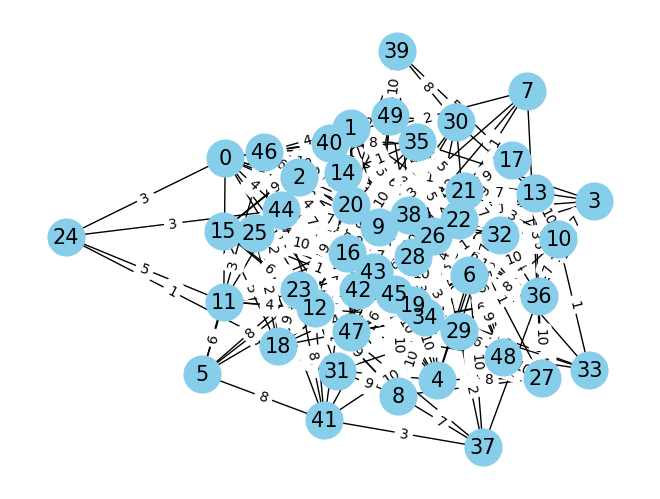

In [1]:
import random
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def generate_max_cut_problem(num_vertices, edge_prob=0.5, weight_range=(1, 10)):
    """
    Generates a random Erdős-Rényi graph for the Max Cut problem.

    Parameters:
        num_vertices (int): Number of vertices in the graph.
        edge_prob (float): Probability of an edge between any two nodes.
        weight_range (tuple): A tuple (min_weight, max_weight) defining the range
                              of weights for the edges.

    Returns:
        np.array: An adjacency matrix representing the generated graph, where
                  matrix[i][j] contains the weight of the edge between vertices
                  i and j; 0 if no edge exists.
    """
    # Create an Erdős-Rényi graph
    G = nx.erdos_renyi_graph(num_vertices, edge_prob)

    # Initialize an adjacency matrix with zeros
    adjacency_matrix = np.zeros((num_vertices, num_vertices), dtype=int)

    # Assign random weights to the edges
    for (u, v) in G.edges():
        weight = random.randint(*weight_range)
        adjacency_matrix[u][v] = weight
        adjacency_matrix[v][u] = weight  # The graph is undirected

    return adjacency_matrix

def visualize_adjacency_matrix(adj_matrix):
    """
    Visualizes the graph represented by an adjacency matrix.
    
    Parameters:
        adj_matrix (np.array): An adjacency matrix representing the graph.
    """
    # Create an empty graph
    G = nx.Graph()
    
    # Add edges and weights based on the adjacency matrix
    num_vertices = adj_matrix.shape[0]
    for i in range(num_vertices):
        for j in range(i+1, num_vertices):  # Ensure we don't double count edges
            if adj_matrix[i][j] > 0:  # Assuming a weighted graph; adjust as needed
                G.add_edge(i, j, weight=adj_matrix[i][j])
    
    # Position nodes using the spring layout
    pos = nx.spring_layout(G, seed=42)  # Seed for reproducible layout

    # Draw the graph
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=700, edge_color='k', linewidths=1, font_size=15)
    
    # Draw edge labels (weights)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    
    plt.show()

# Example usage with a generated adjacency matrix
num_vertices = 50
edge_prob = 0.2  # Probability of an edge
weight_range = (1, 10)
problem_set = generate_max_cut_problem(num_vertices, edge_prob, weight_range)
print(problem_set)
visualize_adjacency_matrix(problem_set)


In [2]:
class Node:
    def __init__(self, parent, node_key, zlb: list, zub: list, model = None, support = []):
        self.parent_dual = parent.dual_value if parent else None
        self.parent_primal = parent.primal_value if parent else None
        self.level = parent.level + 1 if parent else 0
        self.zlb = zlb
        self.zub = zub
        self.z = None
        self.upper_bound = None
        self.primal_value = None
        self.dual_value = None
        self.support = parent.support.copy() if parent and support is None else support
        self.upper_z = None
        self.primal_beta = None
        self.node_key = node_key
        self.opt_gap = 0
        self.parent_key = None
        self.is_leaf = True
        self.left = None
        self.right = None
        self.state = None 
    def get_info(self):
        return f'node_key: {self.node_key}, is_leaf: {self.is_leaf}, ' \
            f'state: {self.state}'
    
    def assign_children(self, left_child=None, right_child=None):
        if left_child is not None:
            self.left = left_child
            self.left.parent_key = self.node_key
            self.is_leaf = False
        
        if right_child is not None:
            self.right = right_child
            self.right.parent_key = self.node_key
            self.is_leaf = False

    def __str__(self):
        return f'level: {self.level}, lower cost: {self.primal_value}, ' \
            f'upper cost: {self.upper_bound}'

    def __repr__(self):
        return self.__str__()

    def __lt__(self, other):
        if self.level == other.level:
            if self.primal_value is None and other.primal_value:
                return True
            if other.primal_value is None and self.primal_value:
                return False
            elif not self.primal_value and not other.primal_value:
                return self.parent_primal > \
                       other.parent_cost
            return self.primal_value > other.lower_bound_value
        return self.level < other.level

In [3]:
from pyscipopt import Model, quicksum
import numpy as np

class Problem:
    def __init__(self, graph):
        self.graph = graph
        self.num_nodes = len(graph)
        self.gap_tol = 1e-4
        
    def lower_solve(self, node):
        model = Model("MaxCutRelaxed")
        x = {i: model.addVar(vtype="C", lb=0, ub=1, name=f"x_{i}") for i in range(self.num_nodes)}
        y = {(i, j): model.addVar(vtype="C", lb=0, ub=1, name=f"y_{i}_{j}") for i in range(self.num_nodes) for j in range(i+1, self.num_nodes)}
        obj = quicksum(self.graph[i][j] * y[i, j] for i in range(self.num_nodes) for j in range(i+1, self.num_nodes))
        model.setObjective(obj, "maximize")
        for i in range(self.num_nodes):
            for j in range(i+1, self.num_nodes):
                model.addCons(y[i, j] <= x[i] + x[j])
                model.addCons(y[i, j] <= 2 - x[i] - x[j])
                model.addCons(y[i, j] >= x[i] - x[j])
                model.addCons(y[i, j] >= x[j] - x[i])
        for i in node.zlb:
            model.addCons(x[i] == 0)
        for i in node.zub:
            model.addCons(x[i] == 1)
        print("lower_solve node.zlb node.zub", node.zlb, node.zub)
        model.setIntParam("display/verblevel", 1)
        # model.setParam("presolving/maxrounds", 0)
        # model.setParam("presolving/maxrestarts", 0)
        model.optimize()
        if model.getStatus() == "infeasible":
            return -np.inf, -np.inf
        print(model.getObjVal())
        primal_value = model.getPrimalbound()
        dual_value = model.getDualbound()
        node.primal_value = primal_value
        node.dual_value = dual_value
        node.primal_beta = [model.getVal(x[i]) for i in range(self.num_nodes)]
        node.z = [model.getVal(x[i]) for i in range(self.num_nodes)]
        node.support = [i for i in range(self.num_nodes) if i not in node.zlb and i not in node.zub]
        return primal_value, dual_value
    
    def upper_solve(self, node):
        print("upper_solve node.z", node.z)
        partition = [1 if z >= 0.5 else 0 for z in node.z]  # Simplified rounding based on 0.5 threshold

        cut_value = sum(self.graph[i][j] for i in range(self.num_nodes) 
                        for j in range(i + 1, self.num_nodes) if partition[i] != partition[j])

        node.upper_bound = cut_value
        node.upper_z = partition
        print("upper_solve partition", partition)

        return cut_value


In [4]:
import numpy as np
from copy import deepcopy
from random import choice, choices
import math
from operator import attrgetter
from scipy import optimize as sci_opt
from node import Node

def reverse_lookup(d, val):
  for key in d:
    if d[key] == val:
      return key
    
class tree():
    def __init__(self, problem):
        self.problem = problem
        self.tree_stats = None
        # Algorithm variables - also reset with set_root below
        self.active_nodes = dict()      # Current Nodes
        self.all_nodes = dict()         # All Nodes
        self.step_counter = 0           # Number branch steps taken
        self.node_counter = 0
        self.best_int = math.inf            # Best integer solution objective value
        self.candidate_sol = None           # Best integer solution values
        self.lower_bound = None             # Minimum relaxed value of all nodes
        self.initial_optimality_gap = None  # Initial optimality gap from root node
        self.optimality_gap = None          # Current optimality gap
        self.root = None


    def start_root(self):
        # Initialize root node
        root_node = Node(parent=None, node_key='root_node', zlb=[], zub=[], support=list(range(self.problem.num_nodes)))
        self.active_nodes['root_node'] = root_node
        self.all_nodes['root_node'] = root_node
        self.problem.lower_solve(root_node)
        self.problem.upper_solve(root_node)
        print("root_node.upper_bound", root_node.upper_bound)
        print("root_node.upper_z", root_node.upper_z)
        print("root_node.primal_value", root_node.primal_value)
        self.lower_bound = root_node.primal_value
        if (root_node.upper_bound > self.best_int):
            self.best_int = root_node.upper_bound
            self.candidate_sol = root_node.upper_z
        self.initial_optimality_gap = (self.lower_bound - self.best_int) / self.best_int
        self.optimality_gap = self.initial_optimality_gap
        self.node_counter += 1
        self.root = self.active_nodes['root_node']
        # Return if done
        if self.check_integer_values(root_node) or (self.optimality_gap <= self.problem.gap_tol):
            return(True)
        return(False)

    
    def max_frac_branch(self):
        # Finds node with greatest fractional part
        # The goal of this function is more focused. It identifies the single best candidate (node and variable) for branching based on the criterion of having the maximum fractional part. This is a direct action function that pinpoints where the next branching should occur to efficiently progress toward an integer solution.
        # support in scip's context would mean the set of variables that have not been split on yet, meaning that they have no upper bound or lower bound set yet.
        best_node_key = None
        best_frac = 0
        best_index = None
        for node_key in self.active_nodes:
            node = self.active_nodes[node_key]
            z = [node.z[i] for i in node.support]
            diff = [min(1 - val, val) for val in z]
            max_diff = max(diff)
            potential_j_index = diff.index(max_diff)
            potential_j = node.support[potential_j_index]
            if max_diff > best_frac:
                best_node_key = node_key
                best_frac = max_diff
                best_index = potential_j
        return(best_node_key, best_index)

    def check_integer_values(self, node):
        """
        Checks if each value in node.z is an integer or a float representing an integer (e.g., 1.0).

        Parameters:
            node: The current node in the branch and bound tree, expected to have an attribute z.

        Returns:
            bool: True if all values in node.z are integers or floats representing integers, False otherwise.
        """
        return all(val.is_integer() if isinstance(val, float) else isinstance(val, int) for val in node.z)
    
    def prune(self, node_keys):
        # Iterate through node keys to find those that aren't active
        for node_key in node_keys:
            if self.active_nodes[node_key].primal_value < self.best_int:
                del self.active_nodes[node_key]

    def update_lower_bound(self):
        # Update the best lower bound over all active nodes
        if len(self.active_nodes) == 0:
            self.lower_bound = self.best_int
        else:
            self.lower_bound = max(self.active_nodes.values(), key=attrgetter('primal_value')).primal_value
            self.lower_bound_node_key = reverse_lookup(self.active_nodes, max(self.active_nodes.values(), key=attrgetter('primal_value')))

    def solve_node(self, node_key):
        # Solves a node with CD and updates upper bound 
        curr_node = self.active_nodes[node_key]
        ## here, the lower_solve could return an infeasible solution, so we need to check for that
        primal_value, _ = self.problem.lower_solve(curr_node)
        if primal_value == -np.inf:
            del self.active_nodes[node_key]
        else:
        # Update upper bound by rounding soln
            curr_upper_bound = self.problem.upper_solve(curr_node)
            if curr_upper_bound > self.best_int:
                self.best_int = curr_upper_bound
                self.candidate_sol = curr_node.upper_z
            # Check if an integer solution
            if self.check_integer_values(curr_node):
                if curr_node.primal_value < self.best_int:
                    self.best_int = curr_node.primal_value
                    self.candidate_sol = curr_node.primal_beta
                del self.active_nodes[node_key]

    def step(self, branch_node_key, j):
        # Add State to Node in Tree
        branch_node = self.active_nodes[branch_node_key]
        self.step_counter += 1

        # Create two child nodes
        branch_node = self.active_nodes[branch_node_key]
        new_zlb = branch_node.zlb + [j]
        new_zub = branch_node.zub + [j]
        # Branches for z_max_frac in node branch_node_key and returns True if done
        # Branch to z_max_frac to be 0
        new_support = [index for index in branch_node.support if index != j]
        
        node_name_1 = f'node_{self.node_counter}'
        self.active_nodes[node_name_1] = Node(parent=branch_node, node_key=node_name_1, zlb=new_zlb, zub=branch_node.zub, support=new_support)
        self.node_counter += 1

        # Branch to z_max_frac to be 1
        node_name_2 = f'node_{self.node_counter}'
        self.active_nodes[node_name_2] = Node(parent=branch_node, node_key=node_name_2, zlb=branch_node.zlb, zub=new_zub, support=new_support)
        self.node_counter += 1

        # Store New Nodes in all_nodes Dictionary
        self.all_nodes[node_name_1] = self.active_nodes[node_name_1]
        self.all_nodes[node_name_2] = self.active_nodes[node_name_2]

        # Store Child Nodes in Tree
        branch_node.assign_children(self.active_nodes[node_name_1], self.active_nodes[node_name_2])
        del self.active_nodes[branch_node_key] # Delete Parent from Active Nodes
        
        # Solve relaxations in new nodes
        
        past_upper = self.best_int
        ## solve_node will use the lower solve
        self.solve_node(node_name_1)
        self.solve_node(node_name_2)

        # Check for node eliminations based on upper bound
        if (past_upper < self.best_int):
            self.prune(list(self.active_nodes.keys()))
            
        # Update lower_bound and lower_bound_node_key
        self.update_lower_bound()

        # Update optimality gap
        old_gap = self.optimality_gap
        self.optimality_gap = (self.lower_bound - self.best_int) / self.best_int

        # Update Node optimality Gap
        branch_node.opt_gap = old_gap - self.optimality_gap
        # Return True if solved or within tolerance and False otherwise
        if (len(self.active_nodes) == 0) or (self.optimality_gap <= self.problem.gap_tol):
            return(True, old_gap, self.optimality_gap)
        
        return(False, old_gap, self.optimality_gap)

    def branch_and_bound(self):
        fin_solving = self.start_root()
        if fin_solving:
            return 1, self.candidate_sol, self.optimality_gap
        
        iters = 0
        
        while (not fin_solving) and (iters < 5000):
            # print(f'Iteration {iters}')
            node_key, j = self.max_frac_branch()
            # Take a step
            fin_solving, old_gap, new_gap = self.step(node_key, j)
            iters += 1
        print("self.best_int", self.best_int)
        return(iters, self.candidate_sol, self.optimality_gap)
    

In [5]:
newProblem = Problem(problem_set)
newTree = tree(newProblem)
i, sol, opt_gap = newTree.branch_and_bound()
print(i, sol, opt_gap)
# newProblem = Problem(problem_set)
# newTree = tree(newProblem)
# newTree.start_root()
# print(newTree.active_nodes['root_node'])
# newTree.step('root_node', 0)

lower_solve node.zlb node.zub [] []
1428.0
upper_solve node.z [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
upper_solve partition [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
root_node.upper_bound 0
root_node.upper_z [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
root_node.primal_value 1428.0
lower_solve node.zlb node.zub [0] []
1410.0
upper_solve node.z [0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.

In [20]:
from pyscipopt import Model, quicksum

def solve(adjacency_matrix):
    num_vertices = len(adjacency_matrix)
    model = Model("MaxCut")
    vertex_vars = [model.addVar(vtype="B", name=f"v_{i}") for i in range(num_vertices)]
    
    # Auxiliary variables for each edge to represent if an edge is cut (1) or not (0)
    cut_vars = {}
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            cut_vars[(i, j)] = model.addVar(vtype="C", name=f"cut_{i}_{j}")

    # Objective: Maximize the sum of weights for edges that are cut
    model.setObjective(
        quicksum(adjacency_matrix[i][j] * cut_vars[(i, j)] for i in range(num_vertices) for j in range(i + 1, num_vertices)),
        "maximize"
    )
    
    # Constraints to enforce cut_vars[i, j] = 1 if and only if vertex_vars[i] != vertex_vars[j]
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            model.addCons(cut_vars[(i, j)] <= vertex_vars[i] + vertex_vars[j])
            model.addCons(cut_vars[(i, j)] <= 2 - vertex_vars[i] - vertex_vars[j])
            model.addCons(cut_vars[(i, j)] >= vertex_vars[i] - vertex_vars[j])
            model.addCons(cut_vars[(i, j)] >= vertex_vars[j] - vertex_vars[i])

    model.optimize()
    
    if model.getStatus() == "optimal":
        solution = [model.getVal(var) for var in vertex_vars]
        print("Solution:", solution)
        cut_weight = model.getObjVal()
        print("Max Cut Weight:", cut_weight)
    else:
        print("Problem could not be solved to optimality.")
        solution = None
        cut_weight = None
        
    return solution, cut_weight


solve(problem_set)

feasible solution found by trivial heuristic after 0.0 seconds, objective value 0.000000e+00
presolving:
Solution: [0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Max Cut Weight: 638.0
(round 1, fast)       0 del vars, 0 del conss, 0 add conss, 780 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 0 clqs
(round 2, fast)       0 del vars, 0 del conss, 0 add conss, 1414 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 0 clqs
   (0.0s) running MILP presolver
   (0.0s) MILP presolver (2 rounds): 0 aggregations, 0 fixings, 146 bound changes
(round 3, medium)     0 del vars, 0 del conss, 0 add conss, 1560 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 0 clqs
(round 4, exhaustive) 0 del vars, 0 del conss, 0 add conss, 1560 chg bounds, 0 chg sides, 0 chg coeffs, 3120 upgd conss, 0 impls, 0 clqs
   (0.0s)

([0.0,
  0.0,
  1.0,
  1.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  0.0,
  1.0,
  1.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0],
 638.0)

   0 | 8.330000e+02 | 3.040000e+02 | 174.01%| unknown
  0.1s|     1 |     0 |   616 |     - |    27M |   0 | 820 |3120 |3128 |   8 |  1 |   5 |   0 | 8.280000e+02 | 3.040000e+02 | 172.37%| unknown
r 0.1s|     1 |     0 |   616 |     - |shifting|   0 | 820 |3120 |3128 |   8 |  1 |   5 |   0 | 8.280000e+02 | 4.210000e+02 |  96.67%| unknown
  0.1s|     1 |     0 |   771 |     - |    28M |   0 | 820 |3120 |3136 |  16 |  2 |   5 |   0 | 8.225000e+02 | 4.210000e+02 |  95.37%| unknown
r 0.1s|     1 |     0 |   771 |     - |shifting|   0 | 820 |3120 |3136 |  16 |  2 |   5 |   0 | 8.225000e+02 | 4.420000e+02 |  86.09%| unknown
  0.1s|     1 |     0 |   875 |     - |    28M |   0 | 820 |3120 |3147 |  27 |  3 |   5 |   0 | 8.200000e+02 | 4.420000e+02 |  85.52%| unknown
  0.2s|     1 |     0 |   931 |     - |    29M |   0 | 820 |3120 |3160 |  40 |  4 |   5 |   0 | 8.200000e+02 | 4.420000e+02 |  85.52%| unknown
  0.2s|     1 |     0 |  1003 |     - |    29M |   0 | 820 |3120 |3172 |  52 |  5 |   5 